## Deep RNN para Time Series - TimeDistributed and BatchNormalization

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf

Using TensorFlow backend.


#### Generacion de series temporales Artificiales

In [10]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  
    return series[..., np.newaxis].astype(np.float32)

#### Creacion del Test y Train Set

In [11]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [8]:
np.random.seed(42)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 741us/step - loss: 0.2482 - last_time_step_mse: 0.2132 - val_loss: 0.0867 - val_last_time_step_mse: 0.0732
Epoch 2/20
7000/7000 [==============================] - 5s 653us/step - loss: 0.0569 - last_time_step_mse: 0.0431 - val_loss: 0.0537 - val_last_time_step_mse: 0.0418
Epoch 3/20
7000/7000 [==============================] - 5s 654us/step - loss: 0.0482 - last_time_step_mse: 0.0366 - val_loss: 0.0468 - val_last_time_step_mse: 0.0344
Epoch 4/20
7000/7000 [==============================] - 5s 656us/step - loss: 0.0442 - last_time_step_mse: 0.0324 - val_loss: 0.0435 - val_last_time_step_mse: 0.0305
Epoch 5/20
7000/7000 [==============================] - 5s 652us/step - loss: 0.0410 - last_time_step_mse: 0.0282 - val_loss: 0.0402 - val_last_time_step_mse: 0.0268
Epoch 6/20
7000/7000 [==============================] - 5s 653us/step - loss: 0.0382 - last_time_step_mse: 0.0244 - val_l

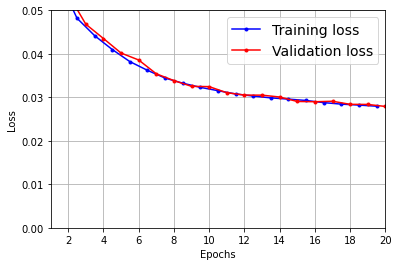

In [9]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()